In [51]:
import numpy as np
import matplotlib.pyplot as plt
import random
from os import listdir
from imageio import read
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from skimage import feature
from skimage.io import imread
from shutil import copy, rmtree

import pandas as pd
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [52]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [53]:
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
%cd '/content/'

/content


# Bag of Words


Aparte de realizar la clasificación de imágenes a partir de redes neuronales convolucionales, hemos querido probar una de las cosas que nos hemos dejado en el tintero durante las prácticas, la técnica de “Bag of Words”. Este concepto nos llamó la atención ya que todo lo que habíamos trabajado había sido con redes CNN pero, en este caso lo que se hacía era extraer un diccionario en base a las imágenes, usando descriptores de las imágenes y viendo que palabras de ese diccionario son a las que más reaccionan para cada imagen. Lo interesante es que estos histogramas que creamos serán los que se usen para entrenar un modelo de machine learning.

Es interesante que pasamos del deep learning usando redes CNN donde lo importante es la no linealidad y donde mostramos la potencialidad de las redes CNN mientras que aquí vamos a usar histogramas para entrenar un modelo.

En primer lugar vamos a explicar que es Bag of Words y es que es una técnica usada para la comparación de imágenes. Se suele usar para clasificación de imágenes. Lo que usamos de entrada para BoW son imágenes en lugar de datos como se suele tener en machine learning donde usamos unas determinadas palabras clave para describir la imágen, pero ¿de qué manera?

![](https://drive.google.com/uc?export=view&id=1DPY4EyECRo0VN-cH9ednc_h3mZ-QHi4q)



En esta técnica para cada imagen de entrada lo que hacemos es calcular una serie de puntos de interés para los cuales obtendremos los descriptores o bien definiremos una zona de la imagen para calcular su descriptor. Un punto de interés o key point es un punto de interés identificable y único que se utiliza para realizar tareas como el reconocimiento de patrones, el seguimiento de objetos, la detección de características y la correspondencia de imágenes. Lo que haremos será obtener estos keypoints para cada una de las imágenes y mediante un algoritmo de clustering, se irán agrupando características similares.

![](https://drive.google.com/uc?export=view&id=1lwRdiSb9OI0dDtJumazm2aBPUfyQKUBa)


Una vez ya tenemos esos descriptores de la imagen lo que hacemos es entrenar un modelo de clustering, en nuestro caso Kmeans el cual irá agrupando descriptores que sean similares, esto nos hace pensar que para la imagen de arriba los descriptores extraidos para cada una de las imágenes tenderán a estar juntos (no siempre es aplicable esto pero en el ejemplo anterior es porque los ejemplos son muy diferentes)


![](https://drive.google.com/uc?export=view&id=15rQbTFbQoqTFNCdpXI7GX4wKmCEDRZCs)




Una vez ya tenemos estos cluster donde las características similares se han agrupado, podemos obtener los centroides de cada cluster que básicamente será la palabra más representativa de cada cluster (Aunque en realidad no es necesario extraerlos).

![](https://drive.google.com/uc?export=view&id=1Lfqe6x0fkPtFe1JqSe9_AbEZKMEDVaHb)


Una vez con esto lo siguiente que se debe hacer es calcular el histograma de cada imagen esto lo haremos definiendo un histograma con tantos cluster como tenga el algoritmo de clustering. Bien, una vez ya entrenado este algoritmo de clustering con los descriptores de cada imagen, de nuevo obtendremos los puntos clave de cada imagen y veremos por cada punto clave a qué cluster se asemeja más, sumando uno al cluster de mayor influencia sobre la característica obteniendo un histograma para cada imágen que será la entrada para nuestro modelo lineal.

![](https://drive.google.com/uc?export=view&id=1DPY4EyECRo0VN-cH9ednc_h3mZ-QHi4q)



# Carga de imagenes que formarán el dataset


In [54]:
%pwd

'/content'

In [55]:
# Creamos unas carpetas que almacenarán las imágenes durante la ejecución del cuarderno
# estas carpetas se borrarán al final del cuaderno
%mkdir train
%mkdir test

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists


In [56]:
# Definimos la ruta a las carpetas para poder acceder a ellas durante la ejecución del programa
root = %pwd
train_path = root + '/train'
test_path = root + '/test'

En primer lugar antes de nada tenemos un dataset donde las imágenes están divididas en coches, camiones y autobuses por lo cuál a partir de estas imagenes generaremos nuestro dataset de train y test.

Lo que hacemos es tomar los nombres de las imagenes del directorio y hacerle un shuffle, después nos quedamos con el 80% de los nombres para train y el restante 20% para test por lo que guardamos las imagenes correspondientes al 80% en train a partir del vector al que hemos hecho shuffle y lo mismo para test.

También decir que le cambiamos el nombre al guardarlas en el nuevo directorio esto para que más adelante sea facil obtener el label para nuestros modelos de machine learning ya que el nombre que tienen de la carpeta original no es muy representativo.

In [57]:
labels = ['bus/', 'car/', 'truck/']


path_img = "/content/drive/MyDrive/Colab Notebooks/PF VC/dataset_bow/"


for label in labels:
  path_img_lbl = path_img + label
  print(path_img_lbl)

  l_c_imgs = listdir(path_img_lbl)
  random.shuffle(l_c_imgs)

  test_examples = int(len(l_c_imgs)*0.2)

  train_l_imgs = l_c_imgs[:-test_examples]
  test_l_imgs = l_c_imgs[-test_examples:]
  print(len(train_l_imgs))
  print(len(test_l_imgs))

  idx = 0
  for img_train in train_l_imgs:
    copy_path = train_path + "/" + label[:-1] + str(idx) + ".jpg"
    copy(path_img_lbl + img_train, copy_path)
    idx += 1

  idx = 0
  for img_test in test_l_imgs:
    copy_path = test_path + "/" + label[:-1] + str(idx) + ".jpg"
    copy(path_img_lbl + img_test, copy_path)
    idx += 1



/content/drive/MyDrive/Colab Notebooks/PF VC/dataset_bow/bus/
288
71
/content/drive/MyDrive/Colab Notebooks/PF VC/dataset_bow/car/
301
75
/content/drive/MyDrive/Colab Notebooks/PF VC/dataset_bow/truck/
286
71


# Funciones necesarias para el cálculo de características y descriptores


In [58]:
# Definimos como variables las siguientes carácteristicas que usaremos para LBP
tam_patch = (15,15)
n_patches = 250
random_state = 42

# Con esta funcion extraeremos los patches de una imagen segun el tamaño y número definidos,
# esta función la usaremos para hacer LBP con dense features para bag of words
# de esta manera será en la que consigamos extraer los patches
def get_patches(img_file, random_state, tam_patch=(11,11), n_patches=250):
  img = imread(img_file)
  #print(img_file)

  patch = extract_patches_2d(img, patch_size = tam_patch, max_patches = n_patches, random_state = random_state)

  # Hacemos un reshape para que cada fila represente un parche
  # La forma de cada parche se determina multiplicando las dimensiones del parche y el número de canales en la imagen (por si esta en gris o RGB)
  return_arr = patch.reshape((n_patches, np.prod(tam_patch) * len(img.shape)))
  return return_arr


In [59]:
# Para una determinada ruta de imagenes llama a la funcion anterior
# en paralelo para más rapidez
def get_img_patches(path_imgs, debug = 0):
  # Lista de imágenes en el directorio especificado
  #print(path_imgs)
  l_imgs = listdir(path_imgs)
  # Obtenemos el número total de imágenes
  n_imgs = len(l_imgs)

  # Utilizamos Parallel para procesar en paralelo la extracción de parches de cada imagen
  # ya que no dependen unas imagenes de otras a la hora de extraer los parches
  # podemos acelerar el proceso de esta forma, todos los patches finalmente
  # serán guardados en patch_arr

  patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(path_imgs+arq_img,
                                                      random_state,
                                                      tam_patch,
                                                      n_patches)
                                for arq_img in l_imgs)


  print('Patches extracted to create dictionary of features')
  print('Total of Images = ', len(patch_arr))
  #El shape de cada patch es del tamaño 15x15 (tamaño del patch) por el número de canales de la imagen
  # por lo que si es RGB sería 15x15x3 = 675
  print('Size of each array of patches = ', patch_arr[0].shape)

  # Con este plot podemos mostrar algunos de los patches escogidos de las imágenes
  # la img para la que se mostraran los patches se determina con el parámetro img_ind
  # como img_ind está en 0 mostrará los patches de la primera imagen.

  img_ind = 5
  plt.figure(figsize=(8,3))
  for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1],3)))
    plt.axis('off')

  return patch_arr

In [60]:
# Esta es la función que usaremos para extraer carácterísticas de los patches
# se pueden utilizar varias como se muestran en la presentación de teoría (sift, lbp, haralick, hog, etc)
def lbp_features(img, radius = 1, sampling_pixels = 8):

  # Pasamos la imagen a escala de grises si es RGB
  if(len(img.shape)>2):
    img = img.astype(float)
    img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

  img = img.astype(np.uint8)

  #Esto es para normalizar los valores de la img
  i_min = np.min(img)
  i_max = np.max(img)
  if (i_max - i_min != 0):
    img = (img - i_min)/(i_max - i_min)


  # Extraemos las características LBP para cada img
  # la img que llega aquí es un patch y 225 carácteristicas
  # ya que hemos pasado de RGB a GrayScale por lo que ahora es 15x15x1 ya que solo hay un canal
  lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method = 'uniform')

  # Obtenemos el histograma para los LBP de la imagen
  (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

  # Normalizamos el histograma
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)

  #plt.hist(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3))
  #plt.show()

  return hist


In [61]:
# Esta es la funcion que usaremos para ir llamando para obtener los LBP de la imagen
# una vez ya obtenidos los patches de la imagen por lo que en primer lugar
# tenemos que hacer un reshape para que el array en lugar de estar ordenado por imagenes
# este ordenado por patches y extraer los LBP de cada uno de los patches
def get_img_features(patch_arr, n_imgs, feature_type = 1, debug=0):
  patch_arr_c = np.array(patch_arr, copy=True)
  patch_arr_c = patch_arr_c.reshape((patch_arr_c.shape[0] * patch_arr_c.shape[1], tam_patch[0],tam_patch[0],3))

  patch_lbp = []

  if feature_type == 1:
    for pat in patch_arr_c:
            f = lbp_features(pat,2,10)
            patch_lbp.append(f)

  patch_lbp = np.array(patch_lbp, copy=False)
  print('Instances = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
  print('Created LBP feature spaces')
  print('\tpatches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
  print("\n")

  return patch_lbp

In [62]:
# Función que llamaremos para calcular los keypoints y descriptores de una imagen
# usando sift
def sift_features(im):
    im=cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create(nfeatures=5000)
    kp, ds = sift.detectAndCompute(im, None)

    return kp, ds

In [63]:
# Función que llamaremos para calcular los keypoints y descriptores de una imagen
# usando hog, en este apartado tenemos que tener cuidado ya que no todos tienen el mismo
# tamaño de salida hay imagenes con más características de este tipo que otras por lo cual
# para que todas tengan el mismo tamaño y poder enseñar al algoritmo de kmeans he puesto
# una longitud máxima que almenos todas las imagenes tienen.
def hog_features(im, debug=False):
  im=cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
  orientations = 8
  pixels_per_cell = (8, 8)
  cells_per_block = (2, 2)

  # Calculate HOG features for the entire image
  hog_features, hog_image = hog(im, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                cells_per_block=cells_per_block, visualize=True, block_norm='L2-Hys')


  if debug:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.title('Original Image in GrayScale')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap=plt.cm.gray)
    plt.title('HOG Image')

    plt.show()

  desired_length = 800  # Establece la longitud máxima deseada
  hog_features = hog_features[:desired_length]

  return hog_features.reshape(1,-1)

In [64]:
# Con esta funcion lo que haremos sera obtener en base a la ruta y el tipo de descriptor
# las caracteristicas en base a ese descriptor y los labels de cada imagen.
def get_features_of_path(path, descriptor_type):
  labels = []
  l_imgs = listdir(path)

  for img in l_imgs:
    if "car" in img:
      labels.append(0)
    elif "bus" in img:
      labels.append(1)
    elif "truck" in img:
      labels.append(2)

  if descriptor_type == 0:
    n_imgs = len(l_imgs)
    patch_arr = get_img_patches(path + "/", debug=1)
    features = get_img_features(patch_arr, n_imgs)

  elif descriptor_type == 1:
    features = []
    for img_n in l_imgs:
      img = imread(path + "/" +img_n)
      kp, ds = sift_features(img)
      features.append(ds)
      #print(ds.shape)
    features = np.vstack(features)

  elif descriptor_type == 2:
    features = []
    for img_n in l_imgs:
      img = imread(path + "/" +img_n)
      ds = hog_features(img)
      features.append(ds)
      #print(ds.shape)
    features = np.vstack(features)

  return features, labels

# Con esta funcion lo que hacemos es calcular el histograma de cada una de las imagenes en un path
# una vez ya esta entrenado el modelo kmeans para ver sobre que "codewords" tiene más influencia
# esa imagen
def get_img_ft(descriptor_type, is_train, kmeans_model, features_extracted, img_path):
  img_feats = []

  if is_train and descriptor_type < 2:
    plt.scatter(features_extracted[:, 0], features_extracted[:, 1], c=kmeans_model.labels_)
    plt.title('2 LBP components and its labels')

  if descriptor_type == 0:
    total_img = int(features_extracted.shape[0] / 250)
    total_img


    # Ahora lo que vamos a hacer ver cuanto de cada cluster
    # aparece en nuestra imagen calculando el histograma de la imagen
    # en base a la prediccion del modelo de clustering

    move = 250
    for i in range(total_img):
        y = kmeans_model.predict(features_extracted[i*move: (i*move)+move])
        hist_bof,_ = np.histogram(y, bins=range(n_dic+1), density=True)
        img_feats.append(hist_bof)


    # De esta manera ya tendriamos el histograma de cada imagen para
    # los patches que se han formado con el modelo de clustering
    img_feats = np.array(img_feats, copy=False)

  #### SIFTTT
  elif descriptor_type == 1:
    l_imgs = listdir(img_path + "/")
    for img_n in l_imgs:
        img = imread(img_path + "/" + img_n)
        kp, ds = sift_features(img)

        # If no keypoints are found, return a zero descriptor
        if ds is None:
            ds = np.zeros(kmeans_model.n_clusters)

        # Assign each descriptor to a cluster
        cluster_assignments = kmeans_model.predict(ds)

        # Create a histogram of cluster assignments
        histogram, _ = np.histogram(cluster_assignments, bins=np.arange(kmeans_model.n_clusters + 1))
        img_feats.append(histogram)
    # Convert the list of descriptors into a numpy array
    img_feats = np.array(img_feats)

  elif descriptor_type == 2:
    l_imgs = listdir(img_path + "/")
    for img_n in l_imgs:
        img = imread(img_path + "/" + img_n)
        ds = hog_features(img)

        # If no keypoints are found, return a zero descriptor
        if ds is None:
            ds = np.zeros(kmeans_model.n_clusters)

        # Assign each descriptor to a cluster

        cluster_assignments = kmeans_model.predict(ds.reshape(1, -1))

        # Create a histogram of cluster assignments
        histogram, _ = np.histogram(cluster_assignments, bins=np.arange(kmeans_model.n_clusters + 1))
        img_feats.append(histogram)
    # Convert the list of descriptors into a numpy array
    #print(ds.reshape(1, -1), ds.reshape(1, -1).shape)
    img_feats = np.array(img_feats)


  print('Number of images and features = ', img_feats.shape)
  print('\n')


  return img_feats


In [65]:
# Funcion que crea un modelo SVM con kernel RBF muy simple ya que no queremos dar importancia
# a la mejora de los modelos de machine learning ya que no es el foco principal del problema.
# Este modelo SVM es entrenado mediante CV y mostramos metricas y la matriz de confusión para ese CV
# Una vez terminado CV hacemos las predicciones para el test y mostramos tambien las metricas
# y matriz de confusión
def model_svm(df_train, df_test):

  # Tu código original para cargar datos
  X = df_train[df_train.columns[:-1]]
  y = df_train['Value']


  # Aplicar escalamiento de características
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Aplicar PCA para reducir la dimensionalidad
  pca = PCA(n_components=0.99)  # Ajusta el porcentaje de varianza explicada según tus necesidades
  X_pca = pca.fit_transform(X_scaled)

  # Crear el clasificador SVM con kernel RBF y capacidad de generar probabilidades
  svm_classifier = SVC(kernel='rbf', probability=True, random_state=random_state)

  # Crear StratifiedKFold para validación cruzada
  stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Listas para almacenar las etiquetas verdaderas y predichas para cada pliegue
  all_y_true = []
  all_y_pred = []

  # Ciclo sobre cada pliegue
  for train_idx, test_idx in stratified_kfold.split(X_pca, y):
      # Dividir los datos
      X_train, X_test = X_pca[train_idx], X_pca[test_idx]
      y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

      # Entrenar el clasificador SVM
      svm_classifier.fit(X_train, y_train)

      # Hacer predicciones usando el clasificador SVM
      y_pred = svm_classifier.predict(X_test)

      # Agregar etiquetas verdaderas y predichas para la evaluación
      all_y_true.extend(y_test)
      all_y_pred.extend(y_pred)

  # Evaluar el rendimiento general del modelo
  accuracy = accuracy_score(all_y_true, all_y_pred)
  precision = precision_score(all_y_true, all_y_pred, average='weighted')
  recall = recall_score(all_y_true, all_y_pred, average='weighted')
  f1 = f1_score(all_y_true, all_y_pred, average='weighted')

  print("\nMETRICS IN CV")

  print("\nOverall Test Accuracy:", accuracy)
  print("Weighted Precision:", precision)
  print("Weighted Recall:", recall)
  print("Weighted F1 Score:", f1)

  # Generar y mostrar la matriz de confusión
  cm = confusion_matrix(all_y_true, all_y_pred)

  plt.figure(figsize=(6, 4))
  plt.subplot(1,2,1)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix CV Data')

  X_test_scaled = scaler.transform(df_test[df_test.columns[:-1]])

  # Aplicar la misma transformación PCA al conjunto de prueba que se usó en el conjunto de entrenamiento
  X_test_pca = pca.transform(X_test_scaled)

  y_pred_test = svm_classifier.predict(X_test_pca)
  y_true_test = df_test['Value']

  # Evaluar el rendimiento general del modelo
  accuracy = accuracy_score(y_true_test, y_pred_test)
  precision = precision_score(y_true_test, y_pred_test, average='weighted')
  recall = recall_score(y_true_test, y_pred_test, average='weighted')
  f1 = f1_score(y_true_test, y_pred_test, average='weighted')

  print("\nMETRICS IN REAL TEST")

  print("\nOverall Test Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  print("\n")


  # Generar y mostrar la matriz de confusión
  cm_test = confusion_matrix(y_true_test, y_pred_test)

  plt.subplot(1,2,2)
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix Test Data')

  plt.show()

# Funcion que crea un modelo RF con n_stimators = 100 muy simple.
# Este modelo RG al igual que el anterior es entrenado mediante CV y
# mostramos metricas y la matriz de confusión para ese CV
# Una vez terminado CV hacemos las predicciones para el test y mostramos tambien las metricas
# y matriz de confusión
def model_rf(df_train, df_test):

  # Tu código original para cargar datos
  X = df_train[df_train.columns[:-1]]
  y = df_train['Value']


  # Aplicar escalamiento de características
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Aplicar PCA para reducir la dimensionalidad
  pca = PCA(n_components=0.99)  # Ajusta el porcentaje de varianza explicada según tus necesidades
  X_pca = pca.fit_transform(X_scaled)

  # Crear el clasificador SVM con kernel RBF y capacidad de generar probabilidades
  rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)

  # Crear StratifiedKFold para validación cruzada
  stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Listas para almacenar las etiquetas verdaderas y predichas para cada pliegue
  all_y_true = []
  all_y_pred = []

  # Ciclo sobre cada pliegue
  for train_idx, test_idx in stratified_kfold.split(X_pca, y):
      # Dividir los datos
      X_train, X_test = X_pca[train_idx], X_pca[test_idx]
      y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

      # Entrenar el clasificador SVM
      rf_classifier.fit(X_train, y_train)

      # Hacer predicciones usando el clasificador SVM
      y_pred = rf_classifier.predict(X_test)

      # Agregar etiquetas verdaderas y predichas para la evaluación
      all_y_true.extend(y_test)
      all_y_pred.extend(y_pred)

  # Evaluar el rendimiento general del modelo
  accuracy = accuracy_score(all_y_true, all_y_pred)
  precision = precision_score(all_y_true, all_y_pred, average='weighted')
  recall = recall_score(all_y_true, all_y_pred, average='weighted')
  f1 = f1_score(all_y_true, all_y_pred, average='weighted')

  print("\nMETRICS IN CV")

  print("\nOverall Test Accuracy:", accuracy)
  print("Weighted Precision:", precision)
  print("Weighted Recall:", recall)
  print("Weighted F1 Score:", f1)

  # Generar y mostrar la matriz de confusión
  cm = confusion_matrix(all_y_true, all_y_pred)

  plt.figure(figsize=(6, 4))
  plt.subplot(1,2,1)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix CV Data')

  X_test_scaled = scaler.transform(df_test[df_test.columns[:-1]])

  # Aplicar la misma transformación PCA al conjunto de prueba que se usó en el conjunto de entrenamiento
  X_test_pca = pca.transform(X_test_scaled)

  y_pred_test = rf_classifier.predict(X_test_pca)
  y_true_test = df_test['Value']

  # Evaluar el rendimiento general del modelo
  accuracy = accuracy_score(y_true_test, y_pred_test)
  precision = precision_score(y_true_test, y_pred_test, average='weighted')
  recall = recall_score(y_true_test, y_pred_test, average='weighted')
  f1 = f1_score(y_true_test, y_pred_test, average='weighted')

  print("\nMETRICS IN REAL TEST")

  print("\nOverall Test Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  print("\n")

  # Generar y mostrar la matriz de confusión
  cm_test = confusion_matrix(y_true_test, y_pred_test)

  plt.subplot(1,2,2)
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix Test Data')
  plt.show()

def train_model_and_get_metrics(df_train, df_test):

  print("\n****SVM MODEL****")
  model_svm(df_train, df_test)
  print("\n")
  print("\n****RF MODEL****")
  model_rf(df_train, df_test)


# Descriptor denso con LBP

Para poder hacer una comparación entre el uso de BoW con distintos descriptores hemos decidido utilizar dense features para la extracción de características de cada imagen en base a los patches que la forman, es decir, hemos decidido obtener para cada imágen un total de 250 patches con un tamaño de 15x15 píxeles. Cada imágen debido a esto tendrá un total de 250 descriptores conformados por 15x15 pixeles (multiplicado por 1 si la imagen está en escala de grises y multiplicado por 3 si la imagen se encuentra en RGB). Es el caso del que veremos a continuacion.


Patches extracted to create dictionary of features
Total of Images =  875
Size of each array of patches =  (250, 675)
Instances =  218750  size =  12
Created LBP feature spaces
	patches =  218750  size =  12


Patches extracted to create dictionary of features
Total of Images =  217
Size of each array of patches =  (250, 675)
Instances =  54250  size =  12
Created LBP feature spaces
	patches =  54250  size =  12




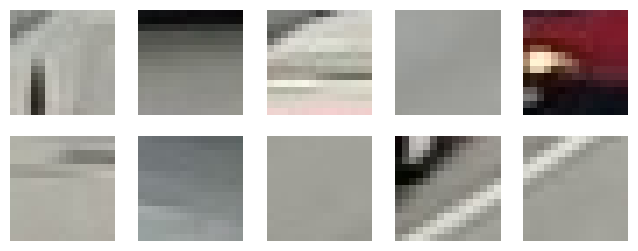

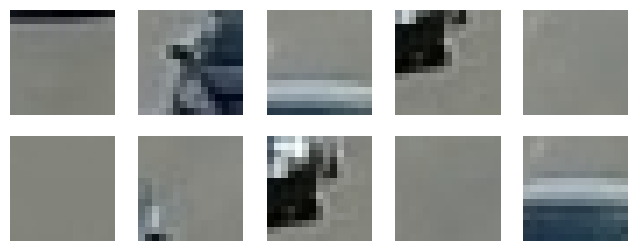

In [66]:
descriptor_type = 0
features_train, labels_train = get_features_of_path(train_path, descriptor_type)
features_test, labels_test = get_features_of_path(test_path, descriptor_type)

Después de obtener estos patches que se muestran en la imagen anterior para cada una de las imágenes de entrada lo que haremos será aplicar para cada patch, LBP, esto para obtener el descriptor de textura para cada patch de cada imagen.

Una vez ya con los descriptores de textura para cada patch de cada imagen lo que haremos será usar un algoritmo de clustering, en nuestro caso Kmeans al cual le diremos que nos agrupe las características en 100 clusters (un número mayor no dio mejores resultados por lo cual no es necesario).


In [67]:
# Ahora vamos a crear un modelo de clustering que
# agrupara carácterísticas similares
# A partir de estos cluster generados debemos de escoger
# las "codewords" mas representativas para ese cluster y
# de esa forma tendremos nuestro "codebook"
# n_dic es el número de codewords que tendremos en nuestro diccionario
n_dic = 100

kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
kmeans_model.fit(features_train)


KMeans(init='random', n_clusters=100, n_init=3, random_state=42, verbose=False)

Una vez ya entrenado este algoritmo, solo tenemos que para cada imagen ver que patches se agrupan en que clusters para obtener su histograma y una vez ya tenemos ese histograma para cada imagen el resto es entrenar el modelo de machine learning.



Number of images and features =  (875, 100)


Number of images and features =  (217, 100)




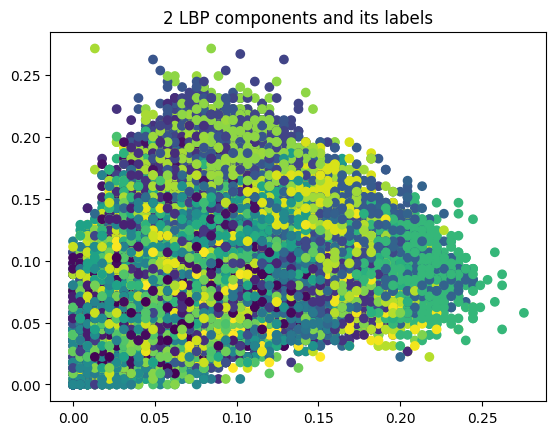

In [68]:
img_feats_train = get_img_ft(descriptor_type, True,  kmeans_model, features_train, train_path)
img_feats_test = get_img_ft(descriptor_type, False, kmeans_model, features_test, test_path)

In [69]:
df_train = pd.DataFrame(img_feats_train)
df_train['Value'] = labels_train

df_test = pd.DataFrame(img_feats_test)
df_test['Value'] = labels_test

for col in df_train.columns[:-1]:
    # Get the minimum and maximum values of the column
    min_value = df_train[col].min()
    max_value = df_train[col].max()

    # Normalize each element in the column
    df_train[col] = (df_train[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Value
0,0.000000,0.388889,0.117647,0.000000,0.30,0.3125,0.357143,0.00,0.000000,0.000000,...,0.000000,0.1250,0.107143,0.3750,0.000000,0.000000,0.1250,0.250000,0.00,2
1,0.000000,0.222222,0.352941,0.000000,0.15,0.0000,0.071429,0.00,0.000000,0.000000,...,0.000000,0.0000,0.321429,0.6875,0.058824,0.000000,0.3750,0.000000,0.00,1
2,0.266667,0.111111,0.470588,0.047619,0.30,0.1250,0.214286,0.05,0.105263,0.214286,...,0.315789,0.0000,0.142857,0.0625,0.000000,0.055556,0.1250,0.000000,0.15,2
3,0.000000,0.111111,0.294118,0.000000,0.40,0.3750,0.000000,0.00,0.000000,0.000000,...,0.000000,0.0000,0.142857,0.0625,0.058824,0.000000,0.2500,0.333333,0.05,1
4,0.000000,0.222222,0.117647,0.000000,0.20,0.0000,0.214286,0.00,0.000000,0.000000,...,0.000000,0.0000,0.142857,0.2500,0.000000,0.000000,0.0000,0.333333,0.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0.200000,0.111111,0.117647,0.047619,0.10,0.1875,0.357143,0.35,0.368421,0.000000,...,0.000000,0.3125,0.142857,0.0625,0.235294,0.055556,0.5625,0.166667,0.40,1
871,0.133333,0.388889,0.117647,0.142857,0.15,0.2500,0.214286,0.25,0.000000,0.000000,...,0.052632,0.2500,0.071429,0.0000,0.117647,0.111111,0.2500,0.333333,0.25,1
872,0.333333,0.111111,0.000000,0.047619,0.05,0.0000,0.357143,0.20,0.000000,0.000000,...,0.105263,0.0625,0.071429,0.1875,0.117647,0.111111,0.0625,0.000000,0.00,0
873,0.000000,0.055556,0.058824,0.000000,0.25,0.0000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.0000,0.250000,0.2500,0.000000,0.000000,0.1875,0.250000,0.00,2



****SVM MODEL****

METRICS IN CV

Overall Test Accuracy: 0.6674285714285715
Weighted Precision: 0.6703559380945558
Weighted Recall: 0.6674285714285715
Weighted F1 Score: 0.6673538861693575

METRICS IN REAL TEST

Overall Test Accuracy: 0.7419354838709677
Precision: 0.7457863115238594
Recall: 0.7419354838709677
F1 Score: 0.7416342313957763




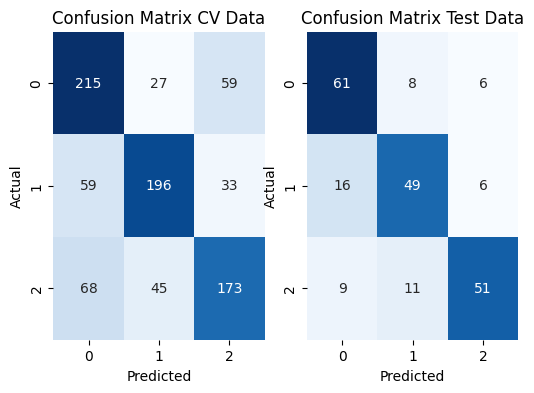




****RF MODEL****

METRICS IN CV

Overall Test Accuracy: 0.6251428571428571
Weighted Precision: 0.624468990162478
Weighted Recall: 0.6251428571428571
Weighted F1 Score: 0.6226990387352619

METRICS IN REAL TEST

Overall Test Accuracy: 0.6359447004608295
Precision: 0.6363582253280484
Recall: 0.6359447004608295
F1 Score: 0.634815865342683




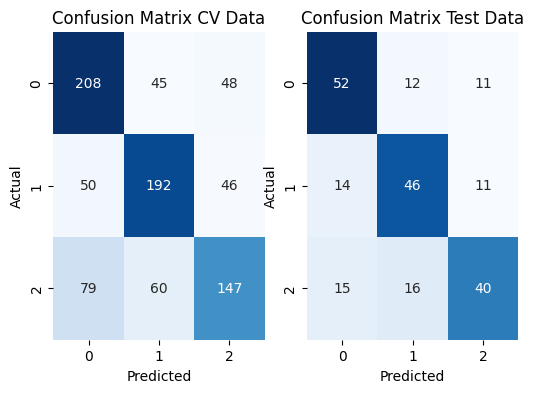

In [70]:
train_model_and_get_metrics(df_train, df_test)

Como podemos ver en este caso el SVM ha actuado de una mejor forma que el RF, debemos tener en cuenta que no hemos cambiado ningun parámetro de estos modelos por lo que no lo hacen todo lo bien que deberian. Aún así vemos que el resultado es bastante bueno ya que en unos pocos segundos podemos tener un accuracy del 0.69 con SVM

# Descriptor denso con HoG

En este caso usaremos como descriptor HoG. La idea principal detrás de HOG es capturar la información sobre la distribución de gradientes de intensidad en una imagen. El problema aquí es que creo que las imagenes dada la naturaleza del dataset no van a ser lo suficientemente buenas como para que este descriptor funcione bien.

In [71]:
descriptor_type = 2
features_train, labels_train = get_features_of_path(train_path, descriptor_type)
features_test, labels_test = get_features_of_path(test_path, descriptor_type)

Hacemos lo mismo que en el proceso anterior

In [72]:
n_dic = 100

kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
kmeans_model.fit(features_train)

KMeans(init='random', n_clusters=100, n_init=3, random_state=42, verbose=False)

In [73]:
img_feats_train = get_img_ft(descriptor_type, True,  kmeans_model, features_train, train_path)
img_feats_test = get_img_ft(descriptor_type, False, kmeans_model, features_test, test_path)

Number of images and features =  (875, 100)


Number of images and features =  (217, 100)




In [74]:
df_train = pd.DataFrame(img_feats_train)
df_train['Value'] = labels_train

df_test = pd.DataFrame(img_feats_test)
df_test['Value'] = labels_test

for col in df_train.columns[:-1]:
    # Get the minimum and maximum values of the column
    min_value = df_train[col].min()
    max_value = df_train[col].max()

    # Normalize each element in the column
    df_train[col] = (df_train[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Value
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1



****SVM MODEL****

METRICS IN CV

Overall Test Accuracy: 0.5245714285714286
Weighted Precision: 0.5299976340405206
Weighted Recall: 0.5245714285714286
Weighted F1 Score: 0.5255694064286501

METRICS IN REAL TEST

Overall Test Accuracy: 0.5299539170506913
Precision: 0.5326136319630491
Recall: 0.5299539170506913
F1 Score: 0.5308582698099655




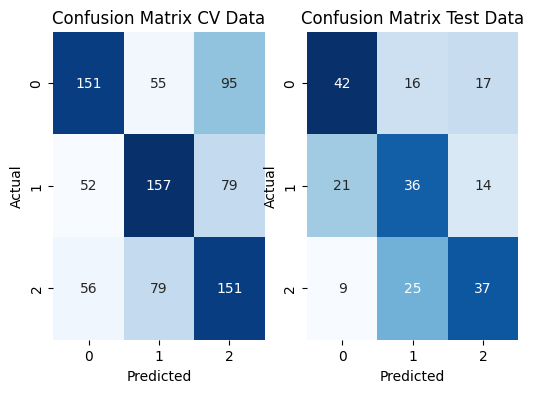




****RF MODEL****

METRICS IN CV

Overall Test Accuracy: 0.5325714285714286
Weighted Precision: 0.5363936954867818
Weighted Recall: 0.5325714285714286
Weighted F1 Score: 0.5334525253239688

METRICS IN REAL TEST

Overall Test Accuracy: 0.5253456221198156
Precision: 0.5234681686294589
Recall: 0.5253456221198156
F1 Score: 0.5236787107754851




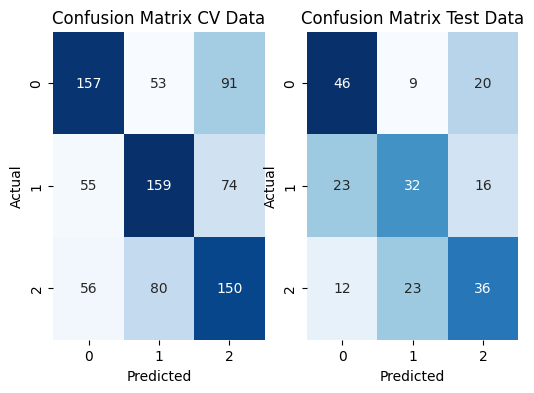

In [75]:
train_model_and_get_metrics(df_train, df_test)

Vemos que el resultado de este descriptor es bastante pobre en ambos modelos en comparación al anterior aunque sigue siendo superior al de una moneda. Esto deja bastante que desear pero vamos a ver el por qué del problema:

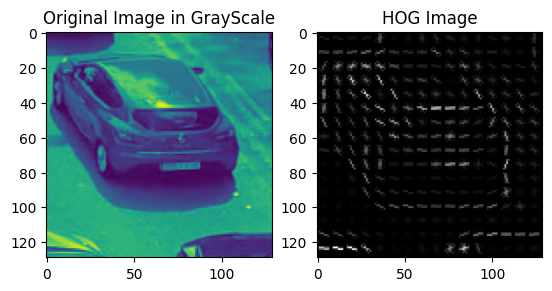

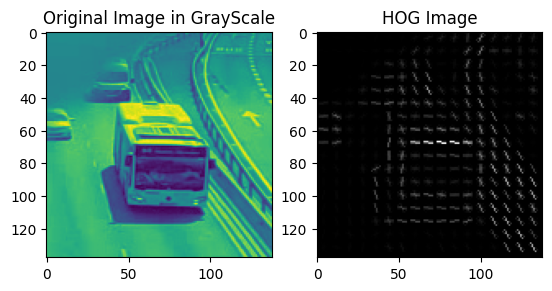

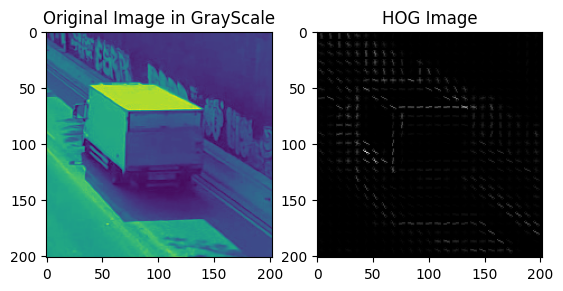

In [76]:
im_coche = train_path + "/car4.jpg"
img = imread(im_coche)
f  = hog_features(img, debug=True)

im_bus = train_path + "/bus1.jpg"
img = imread(im_bus)
f  = hog_features(img, debug=True)

im_truck = train_path + "/truck1.jpg"
img = imread(im_truck)
f  = hog_features(img, debug=True)

Como podemos ver en las imágenes anteriores, hemos mostrado una imagen distinta para cada vehículo de los que hay en nuestro dataset pero podemos ver que su HoG con respecto de los otros es muy pero que muy similar. Podemos concluir diciendo que para este dataset HoG no nos vale como descriptor ya que las HoG asociadas a las imágenes son muy similares y eso hace que sea muy dificil encontrar diferencias.

Por ejemplo si el dataset mostrase fotos de perfil de los vehículos este tipo de descriptor podría ser más representativo.

# Descriptor disperso SIFT

En este caso los descriptores no están basados en la textura sino en los keypoints que el detector sift puede encontrar. Esto hace que se diferencia del anterior y aparte ya no tenemos un “máximo de puntos” como teníamos en el anterior (250 patches por imagen eran 250 descriptores como máximo). Ahora sift tiene total libertad y para cada imágen encontrar un número de keypoints, ni siquiera tiene por qué ser el mismo número para imágenes distintas, hay algunas que tienen 300, otras 400, etc.

En este caso lo que hacemos es obtener los distintos descriptores de puntos haciendo sift para cada imagen y será esto la entrada del algoritmo de clustering Kmeans.


In [77]:
descriptor_type = 1
features_train, labels_train = get_features_of_path(train_path, descriptor_type)
features_test, labels_test = get_features_of_path(test_path, descriptor_type)

De la misma forma que el anterior tendrá un número de 100 cluster y una vez entrenado, deberemos calcular el histograma de cada imagen calculando para cada uno de los descriptores de una imágen a cual se asemejan más de los cluster. Una vez obtenidos estos histogramas el resto es lo mismo que el anterior, entrenar el modelo lineal.

In [78]:
n_dic = 100

kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
kmeans_model.fit(features_train)

KMeans(init='random', n_clusters=100, n_init=3, random_state=42, verbose=False)

Number of images and features =  (875, 100)


Number of images and features =  (217, 100)




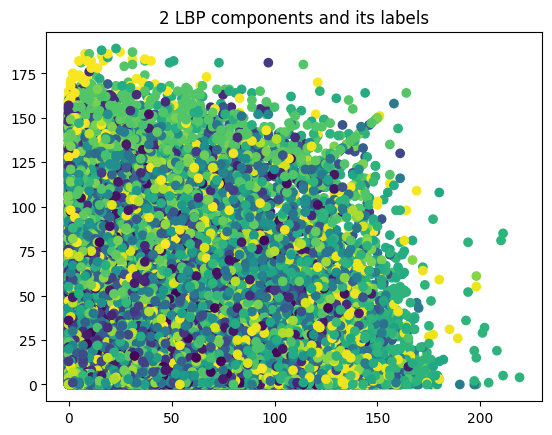

In [79]:
img_feats_train = get_img_ft(descriptor_type, True,  kmeans_model, features_train, train_path)
img_feats_test = get_img_ft(descriptor_type, False, kmeans_model, features_test, test_path)

In [80]:
df_train = pd.DataFrame(img_feats_train)
df_train['Value'] = labels_train

df_test = pd.DataFrame(img_feats_test)
df_test['Value'] = labels_test

for col in df_train.columns[:-1]:
    # Get the minimum and maximum values of the column
    min_value = df_train[col].min()
    max_value = df_train[col].max()

    # Normalize each element in the column
    df_train[col] = (df_train[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Value
0,0.0,0.000000,0.000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.1250,0.083333,0.000000,0.000000,0.2,0.083333,0
1,0.0,0.000000,0.000,0.076923,0.111111,0.000000,0.307692,0.000000,0.000000,0.000000,...,0.0625,0.000000,0.090909,0.0625,0.083333,0.000000,0.111111,0.1,0.166667,2
2,0.1,0.214286,0.000,0.153846,0.111111,0.176471,0.000000,0.000000,0.066667,0.000000,...,0.0625,0.133333,0.090909,0.0625,0.166667,0.078947,0.000000,0.2,0.166667,1
3,0.0,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0625,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,2
4,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.058824,0.066667,0.000000,...,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.222222,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.058824,0.066667,0.000000,...,0.0000,0.000000,0.000000,0.1250,0.083333,0.026316,0.000000,0.0,0.000000,1
871,0.0,0.000000,0.125,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,...,0.0000,0.000000,0.090909,0.0625,0.000000,0.000000,0.111111,0.1,0.083333,0
872,0.0,0.142857,0.000,0.076923,0.111111,0.000000,0.000000,0.000000,0.133333,0.000000,...,0.0000,0.066667,0.181818,0.0000,0.333333,0.000000,0.000000,0.0,0.083333,0
873,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.076923,0.058824,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.0000,0.083333,0.000000,0.000000,0.0,0.083333,1



****SVM MODEL****

METRICS IN CV

Overall Test Accuracy: 0.7497142857142857
Weighted Precision: 0.7691038491689564
Weighted Recall: 0.7497142857142857
Weighted F1 Score: 0.7484237035202518

METRICS IN REAL TEST

Overall Test Accuracy: 0.7788018433179723
Precision: 0.8082523088358898
Recall: 0.7788018433179723
F1 Score: 0.7768997461044304




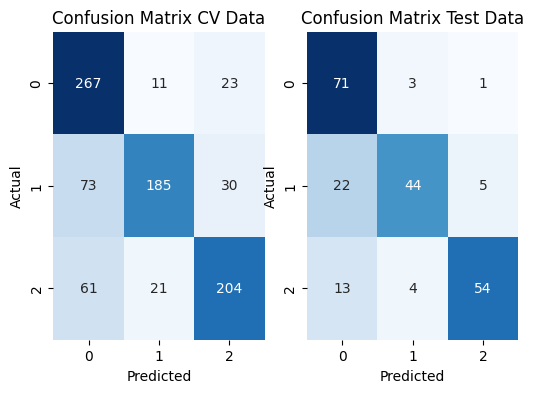




****RF MODEL****

METRICS IN CV

Overall Test Accuracy: 0.7142857142857143
Weighted Precision: 0.7218488657105606
Weighted Recall: 0.7142857142857143
Weighted F1 Score: 0.713411642262369

METRICS IN REAL TEST

Overall Test Accuracy: 0.7603686635944701
Precision: 0.7806371815588404
Recall: 0.7603686635944701
F1 Score: 0.7602465376988597




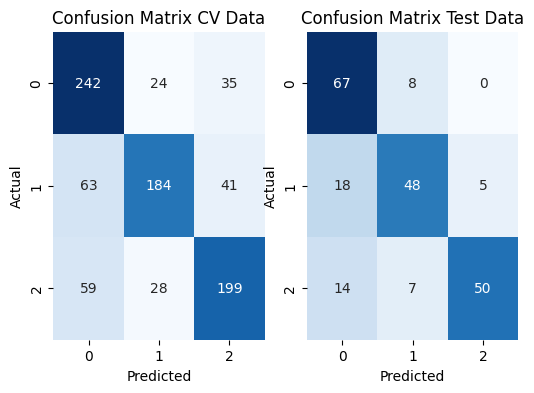

In [81]:
train_model_and_get_metrics(df_train, df_test)

Como podemos ver este es el tipo de descriptor que nos ha funcionado y el que mejor en cuanto a métricas funciona en ambos modelos. Esto nos hace plantearnos diversas cosas ya que en principio los descriptores densos deberían de haber actuado de una mejor forma que sift. Pero esta vez no ha sido así. Podemos suponer que el aplicar características densas con LBP no ha funcionado todo lo mejor que podría por lo que en un futuro se podría probar a hacer dense features con SIFT quizás así puedieramos mejorar esto.

# Conclusión

Finalmente la conclusión que podemos sacar en base a los tres descriptores es que claramente el que mejor funciona de los tres descriptores fijando las mismas condiciones para todos (mismos parámetros en los modelos y mismo número de clústers en kmeans) es SIFT que ha sido el que mejor resultados ha conseguido en la CV. Esto no quiere decir que para otros dataset o cambiando algunos de los hiperparámetros el resto de descriptores no puedan alcanzar un mejor resultado.

Entre HOG y Dense Features con LBP la verdad que nos encontramos limitaciones, en HOG por lo hablado anteriormente de que las imágenes del dataset son muy parecidas por lo que calcular el hog para las imágenes no nos aporta una clara diferencia entre clases, es por esto que es el que peor funciona. Y para LBP decir que es un descriptor de textura y que es cierto que aunque lo usemos para dense features las fotos al igual ser similares no aporta un mejor comportamiento que con sift.

Aun con todo esto debemos de tener en cuenta que Dense Features es una forma muy potente de poder describir imágenes y que debido a la complejidad del dataset no se esta viendo todo su potencial.

También debemos de tener en cuenta que SIFT ha sido el que mejor comportamiento ha tenido y que por esto es uno de los descriptores más fiables y con mayor robustez a día de hoy

# Descriptores densos vs Descriptores dispersos

Un descriptor de imagen es una representación numérica de las características clave de una imagen. Los descriptores densos y dispersos son dos enfoques diferentes para extraer información relevante de una imagen. Como nos surgieron ciertas dudas de sobre por qué ha funcionado mejor sift que dense features aquí hay algunas características de cada tipo de descriptor:

**Descriptor de Imagen Denso:**

Un descriptor denso se calcula para cada punto en la imagen, lo que significa que cubre toda la imagen.

* Mayor Cantidad de Información:
Debido a su enfoque en cada punto, los descriptores densos tienden a contener más información sobre la estructura y los detalles locales de la imagen.

* Mayor Complejidad Computacional:
Calcula descriptores para cada punto en la imagen, lo que puede ser computacionalmente costoso, especialmente para imágenes de alta resolución.

* Menos Robusto a Transformaciones Geométricas:
Puede ser menos robusto a transformaciones geométricas, ya que cada descriptor está asociado con un punto específico y cambios en la posición pueden afectar significativamente los resultados.

**Descriptor de Imagen Disperso:**

* Selección de Puntos Clave:
Los descriptores dispersos se centran en puntos clave seleccionados estratégicamente en la imagen, en lugar de calcular descriptores para cada punto.

* Menor Cantidad de Información:
Al enfocarse en puntos clave, los descriptores dispersos pueden perder información detallada en áreas menos importantes.

* Menor Complejidad Computacional:
Calcula descriptores solo para un conjunto seleccionado de puntos clave, lo que generalmente es menos costoso computacionalmente.

* Más Robusto a Transformaciones Geométricas:
SIFT y otros descriptores dispersos suelen ser más robustos a transformaciones geométricas, ya que están diseñados para ser invariantes a la escala, rotación y traslación.

# Influencia del número de clusters en Kmeans

El número de clusters (k) en un algoritmo de clustering como K-means puede tener un impacto significativo en los resultados obtenidos. Aquí se describen algunas formas en las que el número de clusters puede influir en el rendimiento del algoritmo:

* Overfitting y Underfitting:
  * Si el número de clusters es demasiado bajo, el algoritmo puede agrupar patrones que no son realmente distintos, dando lugar a un bajo rendimiento y a la pérdida de información valiosa (underfitting).

  * Si el número de clusters es demasiado alto, puede haber un riesgo de sobreajuste (overfitting), donde el algoritmo intenta ajustarse demasiado a los datos de entrenamiento y captura ruido en lugar de patrones reales.

* Interpretabilidad:
Un número adecuado de clusters facilita la interpretación de los resultados. Demasiados clusters pueden hacer que la interpretación sea complicada y difícil de analizar, mientras que muy pocos pueden no reflejar adecuadamente la complejidad subyacente de los datos.

* Eficiencia Computacional:
Cuantos más clusters haya, más recursos computacionales serán necesarios para calcular y actualizar los centroides en cada iteración del algoritmo. Esto puede afectar la eficiencia computacional, especialmente en conjuntos de datos grandes.

* Estabilidad de los Resultados:
En algunos casos, variar el número de clusters puede llevar a resultados inestables. Es posible que se desee probar diferentes valores de k y evaluar la estabilidad de los resultados para tomar una decisión informada sobre el número óptimo de clusters.

* Validación del Modelo:
Determinar el número óptimo de clusters puede requerir técnicas de validación del modelo, como la validación cruzada, la silueta o el método del codo, que ayudan a evaluar y comparar la calidad de los clusters obtenidos para diferentes valores de k.

Vamos a probar con 50, 100 y 150 y vamos a ver los resultados que nos arrojan:

Number of images and features =  (875, 50)


Number of images and features =  (217, 50)



****SVM MODEL****

METRICS IN CV

Overall Test Accuracy: 0.7085714285714285
Weighted Precision: 0.7195510561179852
Weighted Recall: 0.7085714285714285
Weighted F1 Score: 0.7068339483394834

METRICS IN REAL TEST

Overall Test Accuracy: 0.7096774193548387
Precision: 0.7491051626078746
Recall: 0.7096774193548387
F1 Score: 0.7075570137993763




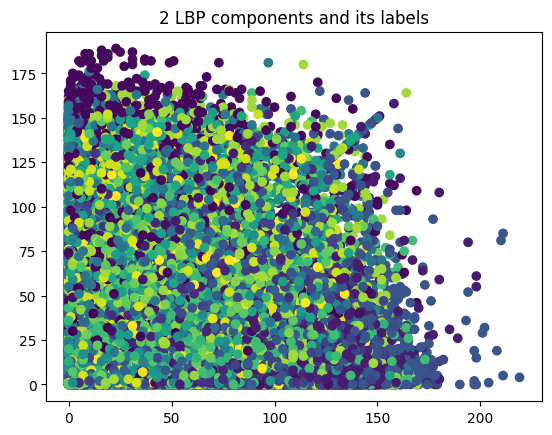

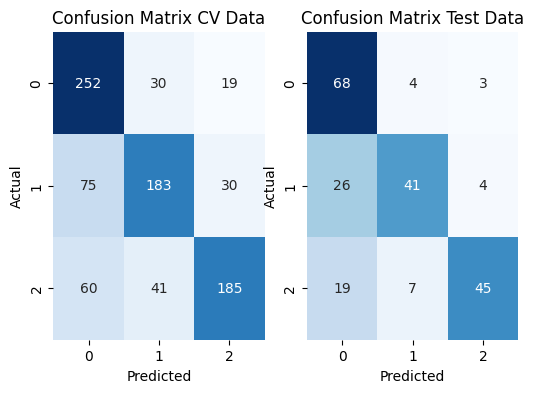




****RF MODEL****

METRICS IN CV

Overall Test Accuracy: 0.6742857142857143
Weighted Precision: 0.677240029639665
Weighted Recall: 0.6742857142857143
Weighted F1 Score: 0.6740860074963659

METRICS IN REAL TEST

Overall Test Accuracy: 0.7188940092165899
Precision: 0.7298833651979569
Recall: 0.7188940092165899
F1 Score: 0.7167313966684634




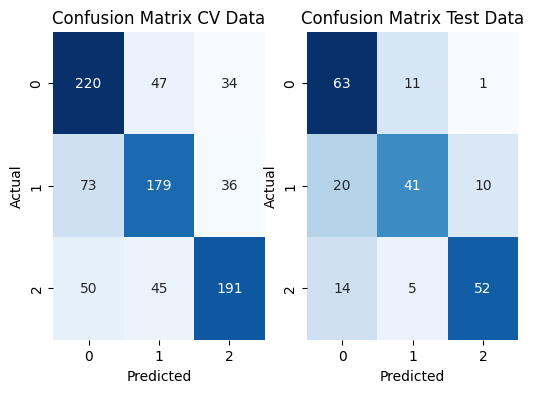

In [82]:
n_dic = 50

kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
kmeans_model.fit(features_train)

img_feats_train = get_img_ft(descriptor_type, True,  kmeans_model, features_train, train_path)
img_feats_test = get_img_ft(descriptor_type, False, kmeans_model, features_test, test_path)

df_train = pd.DataFrame(img_feats_train)
df_train['Value'] = labels_train

df_test = pd.DataFrame(img_feats_test)
df_test['Value'] = labels_test

for col in df_train.columns[:-1]:
    # Get the minimum and maximum values of the column
    min_value = df_train[col].min()
    max_value = df_train[col].max()

    # Normalize each element in the column
    df_train[col] = (df_train[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

df_train = df_train.sample(frac=1).reset_index(drop=True)

train_model_and_get_metrics(df_train, df_test)

Number of images and features =  (875, 100)


Number of images and features =  (217, 100)



****SVM MODEL****

METRICS IN CV

Overall Test Accuracy: 0.7382857142857143
Weighted Precision: 0.7546831732115552
Weighted Recall: 0.7382857142857143
Weighted F1 Score: 0.7360748072578615

METRICS IN REAL TEST

Overall Test Accuracy: 0.783410138248848
Precision: 0.8113207069428268
Recall: 0.783410138248848
F1 Score: 0.7818075452714284




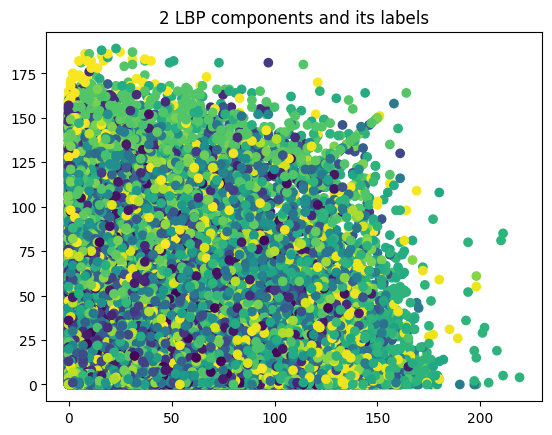

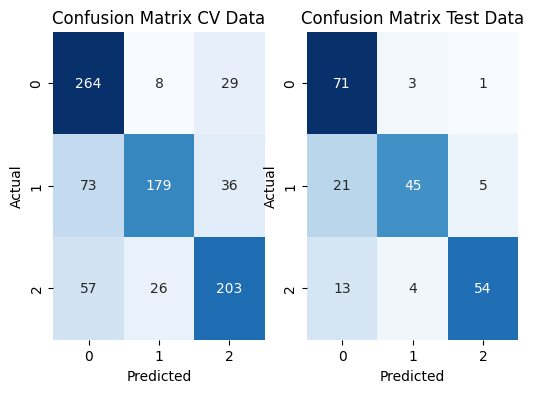




****RF MODEL****

METRICS IN CV

Overall Test Accuracy: 0.696
Weighted Precision: 0.7018993670273996
Weighted Recall: 0.696
Weighted F1 Score: 0.6954134674202398

METRICS IN REAL TEST

Overall Test Accuracy: 0.7419354838709677
Precision: 0.7671088596729014
Recall: 0.7419354838709677
F1 Score: 0.7406323588112436




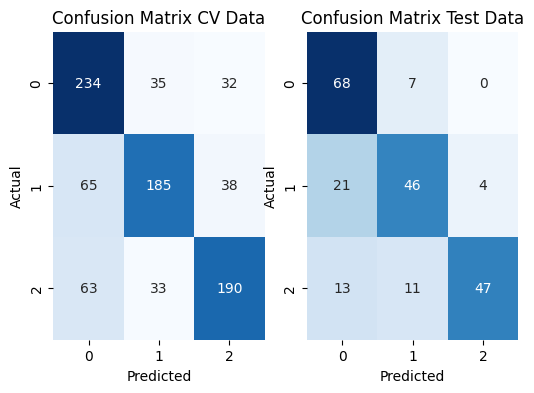

In [83]:
n_dic = 100

kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
kmeans_model.fit(features_train)

img_feats_train = get_img_ft(descriptor_type, True,  kmeans_model, features_train, train_path)
img_feats_test = get_img_ft(descriptor_type, False, kmeans_model, features_test, test_path)

df_train = pd.DataFrame(img_feats_train)
df_train['Value'] = labels_train

df_test = pd.DataFrame(img_feats_test)
df_test['Value'] = labels_test

for col in df_train.columns[:-1]:
    # Get the minimum and maximum values of the column
    min_value = df_train[col].min()
    max_value = df_train[col].max()

    # Normalize each element in the column
    df_train[col] = (df_train[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

df_train = df_train.sample(frac=1).reset_index(drop=True)

train_model_and_get_metrics(df_train, df_test)

Number of images and features =  (875, 150)


Number of images and features =  (217, 150)



****SVM MODEL****

METRICS IN CV

Overall Test Accuracy: 0.7485714285714286
Weighted Precision: 0.7654801342747911
Weighted Recall: 0.7485714285714286
Weighted F1 Score: 0.7482247272240509

METRICS IN REAL TEST

Overall Test Accuracy: 0.7741935483870968
Precision: 0.7952706791416467
Recall: 0.7741935483870968
F1 Score: 0.7742960979985771




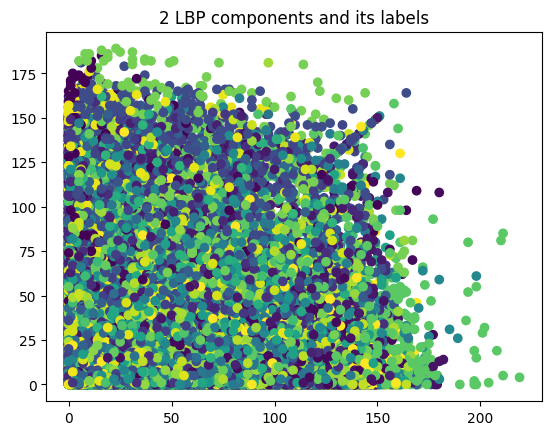

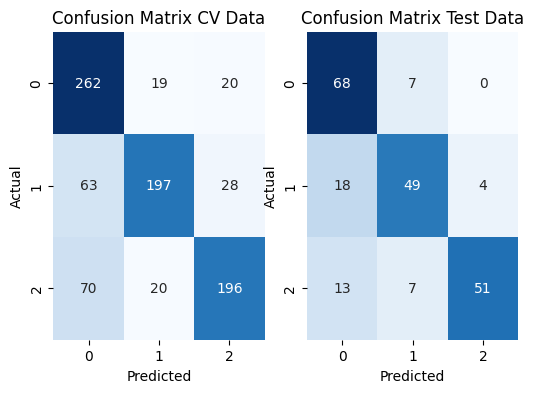




****RF MODEL****

METRICS IN CV

Overall Test Accuracy: 0.6914285714285714
Weighted Precision: 0.6956257073621918
Weighted Recall: 0.6914285714285714
Weighted F1 Score: 0.6907551294670715

METRICS IN REAL TEST

Overall Test Accuracy: 0.7649769585253456
Precision: 0.7874629063845767
Recall: 0.7649769585253456
F1 Score: 0.763408172239801




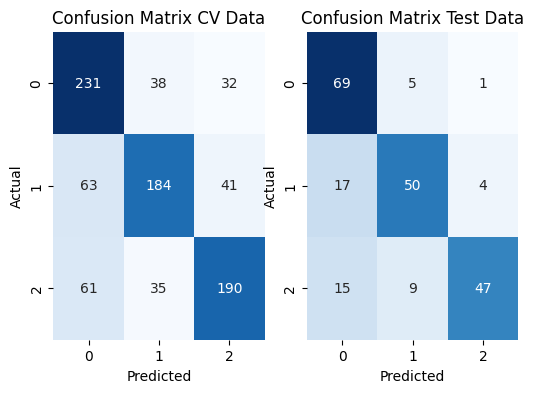

In [84]:
n_dic = 150

kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
kmeans_model.fit(features_train)

img_feats_train = get_img_ft(descriptor_type, True,  kmeans_model, features_train, train_path)
img_feats_test = get_img_ft(descriptor_type, False, kmeans_model, features_test, test_path)

df_train = pd.DataFrame(img_feats_train)
df_train['Value'] = labels_train

df_test = pd.DataFrame(img_feats_test)
df_test['Value'] = labels_test

for col in df_train.columns[:-1]:
    # Get the minimum and maximum values of the column
    min_value = df_train[col].min()
    max_value = df_train[col].max()

    # Normalize each element in the column
    df_train[col] = (df_train[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

df_train = df_train.sample(frac=1).reset_index(drop=True)

train_model_and_get_metrics(df_train, df_test)

Como hemos visto tener un número mayor de cluster no nos asegura un mejor resultado. Aun así aunque tener un mayor numero de cluster nos acerque al overfitting ya que en los modelos aplicamos PCA lo estamos reduciendo por lo cual no va todo lo mal que debería.

Por otra parte vemos que un numero menor de cluster nos lleva a un underfitting teniendo como se ve un menor accuracy.

Por esto es que la elección del número de cluster sea de 100 ya que nos ha aportado un buen resultado durante la ejecución del notebook